In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import re
def extract_number(s):
    match = re.search(r'\d+', s)
    return int(match.group()) if match else None

In [2]:
def calculate_eddy(width=500000, num_depth_layers=21, eta0=1, L=1e5, H=1000, a=1, b=1, rho0=1025, 
                                            f0=None, alpha_1=0.01, alpha_2=0.01, T0=20, dTdz=0.005, dSdz=0.01, taper_depth=None):
    """
    Calculate the 3D geostrophic velocity components U, V, density anomaly sigma, temperature, salinity, 
    and pressure fields for an ocean eddy.

    Parameters:
    - width: Horizontal extent of the grid (eddy scale) in meters.
    - num_depth_layers: Number of vertical layers (depth resolution).
    - eta0: Surface elevation perturbation.
    - L: Horizontal length scale of the eddy in meters.
    - H: Vertical depth scale of the eddy in meters.
    - a, b: Coefficients affecting density anomaly variation.
    - rho0: Reference density (kg/m^3).
    - f0: Coriolis parameter. If None, it will be calculated based on a latitude of -34 degrees.
    - alpha_1, alpha_2: Coefficients affecting eddy center shift with depth.
    - T0: Surface temperature (degrees Celsius).
    - dTdz: Temperature gradient with depth (degrees Celsius per meter).
    - dSdz: Salinity gradient with depth (psu per meter).
    - taper_depth: Tapering scale for vertical variations.

    Returns:
    - U, V: 3D matrices for the U and V (x- and y-components) velocity fields.
    - sigma: 3D matrix for the density anomaly.
    - T: 3D matrix for the temperature field.
    - S: 3D matrix for the salinity field.
    - P: 3D matrix for the pressure field.
    - x, y, z: Horizontal and vertical grid points.
    """

    # Constants
    if f0 is None:
        f0 = 2 * 7.29E-5 * np.sin(np.radians(-34))  # Coriolis parameter for latitude -34 degrees
    g = 9.81  # Gravitational acceleration (m/s^2)

    # Create 2D meshgrid for horizontal space (x, y) and depth (z)
    x = np.linspace(-width // 2, width // 2, 101)  # x-coordinates
    y = np.linspace(-width // 2, width // 2, 101)  # y-coordinates
    z = np.linspace(-H, 0, num_depth_layers)  # Depth levels from surface (0) to -H

    # Create 3D meshgrid
    x_3d, y_3d, z_3d = np.meshgrid(x, y, z, indexing='ij')

    if taper_depth is None:
        taper_factor = np.ones_like(z_3d)
    else:
        taper_factor = np.exp(z_3d / taper_depth)

    # Define the functions f(|r - r_c(z)|) and g(z)
    def f_r_rc(r, L):
        return np.exp(-r**2 / L**2)

    # Calculate the center position as a function of depth
    x_c = alpha_1 * z_3d
    y_c = alpha_2 * z_3d

    # Calculate radial distance r - r_c(z)
    r_c = np.hypot( x_3d - x_c, y_3d - y_c )

    # Temperature field
    # T = T0 + dTdz * z_3d - 2 * f_r_rc(r_c, L) * taper_factor
    T = - 2 * f_r_rc(r_c, L) * taper_factor

    # Salinity field
    S0 = 35  # Reference surface salinity (psu)
    # S = S0 + dSdz * z_3d + 1.5 * f_r_rc(r_c, L) * taper_factor
    S = 1.5 * f_r_rc(r_c, L) * taper_factor

    # Pressure field (hydrostatic pressure)
    P = -rho0 * g * z_3d

    # Density field using a simplified equation of state
    alpha = 0.0002  # Thermal expansion coefficient (1/°C)
    beta = 0.0008  # Haline contraction coefficient (1/psu)
    sigma = rho0 * (1 - alpha * (T - T0) + beta * (S - S0)) 
    sigma -= np.mean(sigma)

    # Calculate geostrophic velocity components
    dx = x[1] - x[0]  # Grid spacing in x
    dy = y[1] - y[0]  # Grid spacing in y
    d_sigma_dx = np.gradient(sigma, axis=0) / dx
    d_sigma_dy = np.gradient(sigma, axis=1) / dy

    U = g / f0 * d_sigma_dy * taper_factor
    V = -g / f0 * d_sigma_dx * taper_factor

    U = np.flip(U, axis=2)
    V = np.flip(V, axis=2)
    sigma = np.flip(sigma, axis=2)
    T = np.flip(T, axis=2)
    S = np.flip(S, axis=2)
    P = np.flip(P, axis=2)
    z = np.flip(z)

    return U, V, sigma, T, S, P, x, y, z


In [3]:
U, V, sigma, T, S, P, x, y, z = calculate_eddy(taper_depth=None)

U_tap, V_tap, sigma_tap, T_tap, S_tap, P_tap, _, _, _ = calculate_eddy(taper_depth=400)

dx, dy, dz = x[1] - x[0], y[1] - y[0], z[1]-z[0]

alpha_1 = dx / dz # tilt in x direction # -100
# alpha_1 = -100

U_tilt, V_tilt, sigma_tilt, T_tilt, S_tilt, P_tilt, _, _, _ = calculate_eddy(taper_depth=None, alpha_1=alpha_1)

U_tilt_tap, V_tilt_tap, sigma_tilt_tap, T_tilt_tap, S_tilt_tap, P_tilt_tap, _, _, _ = calculate_eddy(taper_depth=400, alpha_1=alpha_1)



In [4]:
modelled_data = {
    'Eddy0':{
        'Name': 'E1', 'U': U, 'V': V, 'sigma': sigma, 'T': T, 'S': S, 'P': P
    },
    'Eddy1':{
        'Name': r'E1$_\text{tap}$', 'U': U_tap, 'V': V_tap, 'sigma': sigma_tap, 'T': T_tap, 'S': S_tap, 'P': P_tap
    },
    'Eddy2':{
        'Name': 'E2', 'U': U_tilt, 'V': V_tilt, 'sigma': sigma_tilt, 'T': T_tilt, 'S': S_tilt, 'P': P_tilt
    },
    'Eddy3':{
        'Name': r'E2$_\text{tap}$', 'U': U_tilt_tap, 'V': V_tilt_tap, 'sigma': sigma_tilt_tap, 'T': T_tilt_tap, 'S': S_tilt_tap, 'P': P_tilt_tap
    },
    'x': x, 'y': y, 'z': z
}
eddies = ['Eddy0', 'Eddy1', 'Eddy2', 'Eddy3']

In [5]:
def calc_ow(uu, vv, dx, dy):
    WIDTH, LENGTH, SIGMAS = uu.shape
    u_x = (uu[2:,:,:] - uu[:-2,:,:]) / (2*dx)
    u_y = (uu[:,2:,:] - uu[:,:-2,:]) / (2*dy)
    v_x = (vv[2:,:,:] - vv[:-2,:,:]) / (2*dx)
    v_y = (vv[:,2:,:] - vv[:,:-2,:]) / (2*dy)
    u_x = np.concatenate((np.zeros((1, LENGTH, SIGMAS)), u_x, np.zeros((1, LENGTH, SIGMAS))), axis=0)
    v_x = np.concatenate((np.zeros((1, LENGTH, SIGMAS)), v_x, np.zeros((1, LENGTH, SIGMAS))), axis=0)
    u_y = np.concatenate((np.zeros((WIDTH, 1, SIGMAS)), u_y, np.zeros((WIDTH, 1, SIGMAS))), axis=1)
    v_y = np.concatenate((np.zeros((WIDTH, 1, SIGMAS)), v_y, np.zeros((WIDTH, 1, SIGMAS))), axis=1)
    s_n = u_x - v_y
    s_s = v_x + u_y
    vort = v_x - u_y
    ow = s_n**2 + s_s**2 - vort**2
    return ow
    
def normalize_matrix(matrix, mask_value=np.nan):
    valid_mask = np.where(matrix == mask_value, 0, 1)
    valid_mean = np.nansum(matrix) / np.sum(valid_mask)
    valid_std = np.sqrt(np.nansum(valid_mask * (matrix - valid_mean) ** 2) / np.sum(valid_mask))
    return (matrix - valid_mean) / valid_std



In [6]:
eddies

['Eddy0', 'Eddy1', 'Eddy2', 'Eddy3']

In [7]:
CS_THRESH = 0.3
OW_THRESH = -.2
RATIO_THRESH = 1/3
SEARCH_RADIUS_MAX = 200000

plot_data = {}
x = modelled_data['x']
y = modelled_data['y']
X, Y = np.meshgrid(x, y)
for eddy in eddies:
# for eddy in ['Eddy2']:

    plot_data[eddy] = {}
    plot_data[eddy]['df'] = pd.DataFrame(columns=['xc', 'yc', 'Depth', 'SR'])

    U_eddy = modelled_data[eddy]['U']
    V_eddy = modelled_data[eddy]['V']

    CS = np.hypot(U_eddy, V_eddy)
    OW = normalize_matrix(calc_ow(U_eddy, V_eddy, x[1]-x[0], x[1]-x[0]))
    plot_data[eddy]['CS'] = CS
    plot_data[eddy]['OW'] = OW

    bottom_flag = 0
    xc_pre, yc_pre = 0, 0
    for depth_lvl in range(U_eddy.shape[-1]):
        
        Search_Radius = 50000
        
        if bottom_flag:
            break
            
        u = U_eddy[:, :, depth_lvl]
        v = V_eddy[:, :, depth_lvl]
        cs = CS[:, :, depth_lvl]
        ow = OW[:, :, depth_lvl]

        R = np.hypot(X - xc_pre , Y - yc_pre).T 
        
        while not bottom_flag:
            
            mask = (cs < CS_THRESH) & (ow < OW_THRESH) & (R < Search_Radius)
            
            potential_centers_ind = np.array(np.where(mask)).T
            num_pot, num_search = np.sum(mask), np.sum(R < Search_Radius)

            if num_pot == 0:
                bottom_flag = 1
                break
                
            ratio = num_pot / num_search
            if ratio <= RATIO_THRESH:
                A = np.array([[x[i], y[j]] for i, j in potential_centers_ind])
                xc, yc = np.mean(A, axis=0)
                plot_data[eddy]['df'].loc[len(plot_data[eddy]['df'])] = {
                    'xc': xc, 'yc': yc, 'Depth': z[depth_lvl], 'SR': Search_Radius
                }
                xc_pre, yc_pre = xc, yc
                plot_data[eddy][f'pots{depth_lvl}'] = A
                break
            
            if Search_Radius >= SEARCH_RADIUS_MAX:
                bottom_flag = 1
            else:
                Search_Radius += 5000


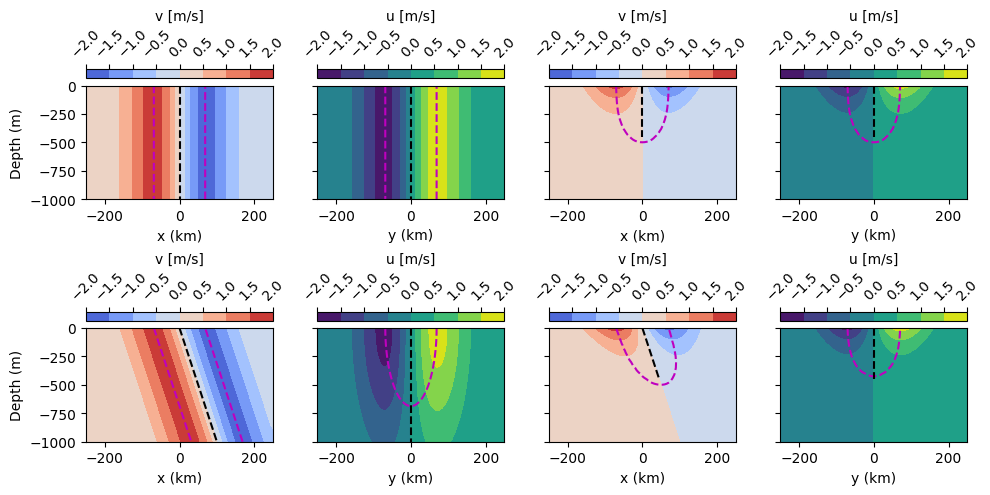

In [8]:
fig, axs = plt.subplots(2, 4, figsize=(10, 5), sharey=True)
x = modelled_data['x']/1000
y = modelled_data['y']/1000
for i, ax_pair in enumerate(axs.reshape(-1, 2)):
    eddy = eddies[i]
    u = modelled_data[eddy]['U'][modelled_data[eddy]['U'].shape[0] // 2, :, :]
    v = modelled_data[eddy]['V'][:, modelled_data[eddy]['V'].shape[1] // 2, :]
    ow = plot_data[eddy]['OW']

    im1 = ax_pair[0].contourf(x, z, v.T, cmap='coolwarm')
    im2 = ax_pair[1].contourf(y, z, u.T)

    df = plot_data[eddy]['df']
    ax_pair[0].plot(df['xc']/1000, df['Depth'], 'k', linestyle='--', zorder=3)
    ax_pair[1].plot(df['yc']/1000, df['Depth'], 'k', linestyle='--', zorder=3)

    ax_pair[0].contour(x, z, ow[:, ow.shape[1]//2, :].T, levels=[-0.2], colors='m', linestyles='dashed', alpha=1)
    ax_pair[1].contour(x, z, ow[ow.shape[0]//2, :, :].T, levels=[-0.2], colors='m', linestyles='dashed', alpha=1)
    
    ax_pair[0].set_xlabel('x (km)')
    ax_pair[1].set_xlabel('y (km)')

    cbar1 = fig.colorbar(im1, ax=ax_pair[0], orientation='horizontal', location='top', label='v [m/s]')
    cbar2 = fig.colorbar(im2, ax=ax_pair[1], orientation='horizontal', location='top', label='u [m/s]')

    # Rotate colorbar ticks
    cbar1.ax.tick_params(axis='x', rotation=45)
    cbar2.ax.tick_params(axis='x', rotation=45)

axs[0, 0].set_ylabel('Depth (m)')
axs[1, 0].set_ylabel('Depth (m)')

plt.tight_layout()
plt.show()


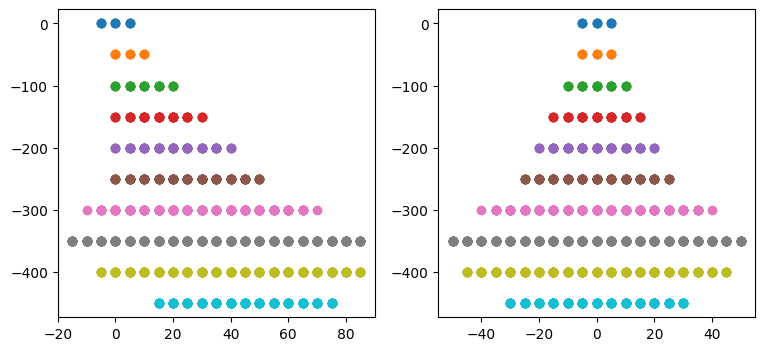

In [9]:
eddy = 'Eddy3'

plot_data[eddy]

fig, axs = plt.subplots(1, 2, figsize=(9,4))

for depth_key in [key for key in plot_data[eddy].keys() if 'pots' in key]:
    depth_lvl = extract_number(depth_key)
    if len(plot_data[eddy][depth_key]) > 0:
        x = plot_data[eddy][depth_key][:, 0]/1000
        y = plot_data[eddy][depth_key][:, 1]/1000
        
        axs[0].scatter(x, [z[depth_lvl]] * len(x))

        axs[1].scatter(y, [z[depth_lvl]] * len(y))
    

    

In [10]:
plot_data[eddy].keys()

dict_keys(['df', 'CS', 'OW', 'pots0', 'pots1', 'pots2', 'pots3', 'pots4', 'pots5', 'pots6', 'pots7', 'pots8', 'pots9'])

In [11]:
plot_data[eddy]['df']

,xc,yc,Depth,SR
0,0.0,0.0,0.0,50000
1,5000.0,0.0,-50.0,50000
2,10000.0,0.0,-100.0,50000
3,15000.0,0.0,-150.0,50000
4,20000.0,0.0,-200.0,50000
5,25000.0,0.0,-250.0,50000
6,30000.0,0.0,-300.0,70000
7,35000.0,0.0,-350.0,95000
8,40000.0,0.0,-400.0,85000
9,45000.0,0.0,-450.0,60000


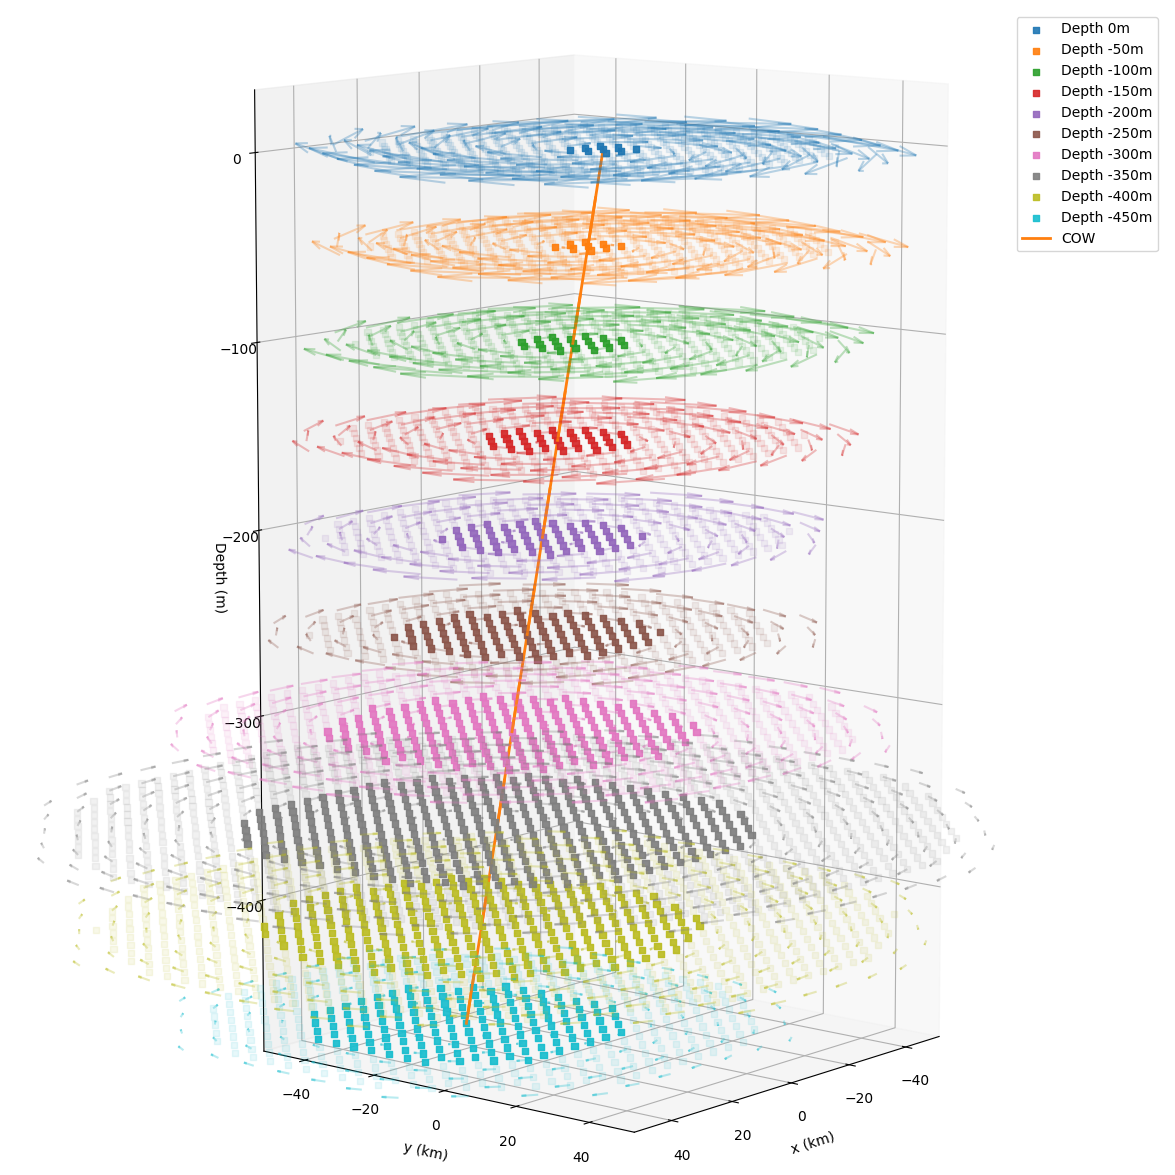

In [14]:
from mpl_toolkits.mplot3d import Axes3D  

x = modelled_data['x']/1000
y = modelled_data['y']/1000
X, Y = np.meshgrid(x, y)

eddy = 'Eddy3'

U = modelled_data[eddy]['U']
V = modelled_data[eddy]['V']

fig = plt.figure(figsize=(15, 15))
ax = fig.add_subplot(111, projection='3d')
colors = plt.cm.tab10.colors * 3

df = plot_data[eddy]['df']

# for i, depth_lvl in enumerate([0, 5, 10, 15]):
for i, depth_lvl in enumerate(list(plot_data[eddy]['df'].index)):

    xc = df.iloc[depth_lvl]['xc']/1000
    yc = df.iloc[depth_lvl]['yc']/1000
    depth = z[depth_lvl]
    A = plot_data[eddy]['pots'+str(depth_lvl)]/1000
    SR = df.iloc[depth_lvl]['SR']/1000
    if depth_lvl == 0:
        xc_pre, yc_pre = 0, 0
    else:
        xc_pre, yc_pre = df.iloc[depth_lvl-1]['xc']/1000, df.iloc[depth_lvl-1]['yc']/1000

    R = np.hypot(X-xc_pre, Y-yc_pre).T
    X_masked = np.where(R.T < SR, X, np.nan)
    Y_masked = np.where(R.T < SR, Y, np.nan)
    ax.scatter(X_masked, Y_masked, [depth] * (X_masked.shape[0]*X_masked.shape[1]), marker='s', alpha=0.1, color=colors[i]) 
    ax.scatter(A[:, 0], A[:, 1], [depth] * len(A[:, 0]), marker='s', alpha=0.9, color=colors[i], label=f'Depth {round(z[depth_lvl])}m') 

    spacing = 2
    scale_factor = 20
    u_masked = np.where(R < SR+10, U[:,:,depth_lvl], np.nan)
    v_masked = np.where(R < SR+10, V[:,:,depth_lvl], np.nan)

    u, v = u_masked[::spacing, ::spacing].T * scale_factor, v_masked[::spacing, ::spacing].T * scale_factor
    XX, YY = X[::spacing, ::spacing], Y[::spacing, ::spacing]
    ax.quiver(XX, YY, depth * np.ones_like(XX), u, v, np.zeros_like(u), color=colors[i], alpha=.3, zorder=0)


ax.plot(df['xc']/1000, df['yc']/1000, df['Depth'], zorder=1, linewidth=2, color=colors[1], label='COW')
for i in range(1, len(df)):
    x_mid = (df['xc'][i]+df['xc'][i-1])/2 / 1000
    y_mid = (df['yc'][i]+df['yc'][i-1])/2 / 1000
    z_mid = (df['Depth'][i]+df['Depth'][i-1])/2 
    ax.plot([df['xc'][i]/1000, x_mid], [df['yc'][i]/1000, y_mid], [df['Depth'][i], z_mid], linewidth=2, color=colors[1],zorder=10)
    
ax.view_init(elev=10, azim=40) #350
ax.set_box_aspect([1, 1, 2]) 
ax.set_xlabel("x (km)")
ax.set_ylabel("y (km)")
ax.set_zlabel("Depth (m)")

ax.set_xlim([-50, 50])
ax.set_ylim([-50, 50])
ax.legend()
plt.show()


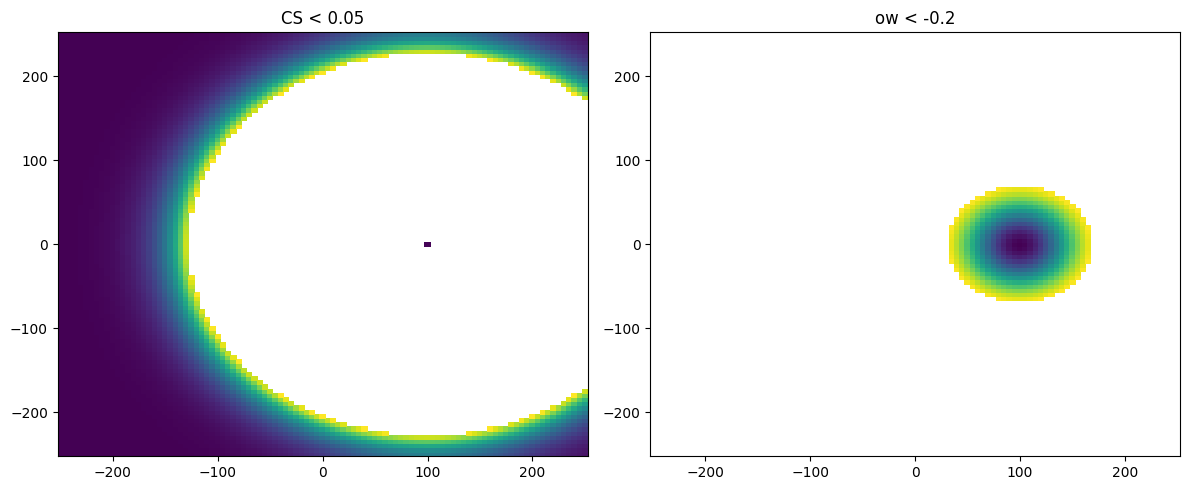

[[70 50]]
[100.] [0.]


In [16]:
depth_lvl = 20

CS = np.hypot(U_tilt[:, :, depth_lvl], V_tilt[:, :, depth_lvl])
ow = plot_data['Eddy2']['OW'][:, :, depth_lvl]

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Plot 1: Points where CS < 0.05
masked_CS = np.where(CS < 0.05, CS, np.nan)
axes[0].pcolor(x, y, masked_CS.T)
axes[0].set_title("CS < 0.05")

# Plot 2: Points where ow < -0.2
masked_ow = np.where(ow < -0.2, ow, np.nan)
axes[1].pcolor(x, y, masked_ow.T)
axes[1].set_title("ow < -0.2")

plt.tight_layout()
plt.show()

mask = (CS < 0.05) & (ow < -0.2)
points = np.array(np.where(mask)).T
print(points)

print(x[points[:,0]], y[points[:,1]])


In [ ]:
x